# Pet Finder

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import pathlib
from matplotlib import pyplot as plt
import PIL

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-05-21 23:05:34.922987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-21 23:05:34.923036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Data manipulation

Our data is stored in a csv file. We will load that file and do some cleanups, such as removing unnecessary columns and unsuitable entries. These entries are those that have more animals in a single entry and those that do not have any photos.

In [2]:
def create_directory(path):
    if os.path.exists(path) and os.path.isdir(path):
        shutil.rmtree(path)
    os.mkdir(path)

In [3]:
df = pd.read_csv('./train.csv')
df = df.query('Quantity == 1 & PhotoAmt > 0')

In [4]:
df = df[['PetID', 'Breed1']]
df.rename(columns={'PetID': 'PetID', 'Breed1': 'Breed'}, inplace=True)
df.shape

(11330, 2)

With our data separated, let's take a look at the breeds and how they vary across cats and dogs.

In [5]:
breed_df = pd.read_csv('./BreedLabels.csv')
breed_df=pd.DataFrame(breed_df)
breed_df.shape

(307, 3)

From the Breed Labels csv file, we know that we have 307 different breeds.
On the next step, let's take a look at how many of them are dog breeds and how many are cat breeds.

Number of dog breeds: 

In [6]:
dog_breeds = breed_df.query(' Type == 1 ')
dog_breeds.shape[0]

241

Number of cat breeds:

In [7]:
cat_breeds = breed_df.query(' Type == 2 ')
cat_breeds.shape[0]

66

In [8]:
df.dtypes

PetID    object
Breed     int64
dtype: object

In [9]:
breed_df = breed_df.astype(str)
breed_df.dtypes

BreedID      object
Type         object
BreedName    object
dtype: object

In [10]:
df['Breed']=df['Breed'].astype(str)

In [11]:
df.head()

,PetID,Breed
0,86e1089a3,299
1,6296e909a,265
2,3422e4906,307
3,5842f1ff5,307
4,850a43f90,307


In [12]:
for index, row in df.iterrows():
    if row['Breed'] in breed_df['BreedID'].values:
        #if Type from breed_df is '1' Species is dog else cat
        if breed_df[breed_df['BreedID'] == row['Breed']]['Type'].values[0] == '1':
            df.at[index, 'Species'] = 'dog'
        else:
            df.at[index, 'Species'] = 'cat'
        df.loc[index, 'Breed'] = breed_df[breed_df['BreedID'] == row['Breed']]['BreedName'].values[0]

In [13]:
df.head()

,PetID,Breed,Species
0,86e1089a3,Tabby,cat
1,6296e909a,Domestic Medium Hair,cat
2,3422e4906,Mixed Breed,dog
3,5842f1ff5,Mixed Breed,dog
4,850a43f90,Mixed Breed,dog


In [14]:
df.query('Species == "dog" & Breed != "Mixed Breed"').shape[0]

1915

With our data frame properly manipulated, we can now split the images in directories for cats and dogs.

In [15]:
train_images_path = './train_images'
out_path = './train/'

create_directory('./train/dogs')
create_directory('./train/cats')

for _, row in df.iterrows():
    if not row['Species'] in ['dog', 'cat']:
        continue

    files = os.listdir(train_images_path)
    pet_id_images = [ os.path.join(train_images_path, image) for image in files if os.path.isfile(os.path.join(train_images_path, image)) and row['PetID'] in image ]
    for image in pet_id_images:
        shutil.copy(image, os.path.join(out_path, row['Species'] + 's'))

<AxesSubplot:xlabel='Species'>

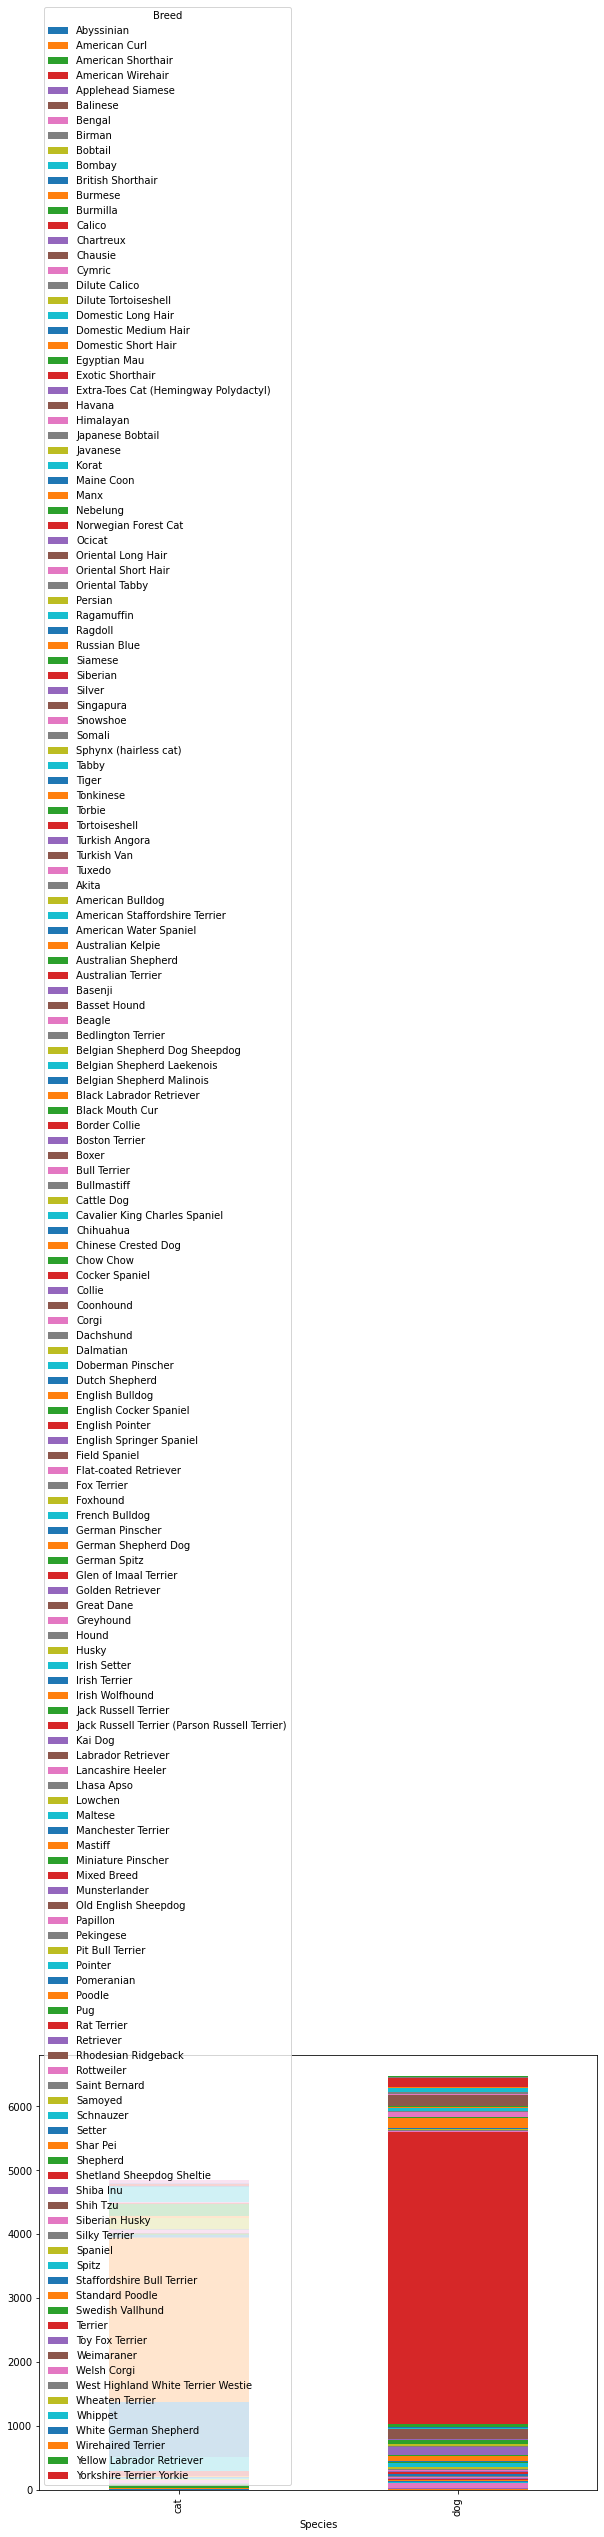

In [16]:
df.groupby(['Species', 'Breed']).count()['PetID'].unstack().plot(kind='bar', stacked=True, figsize=(10, 8))

<AxesSubplot:xlabel='Breed'>

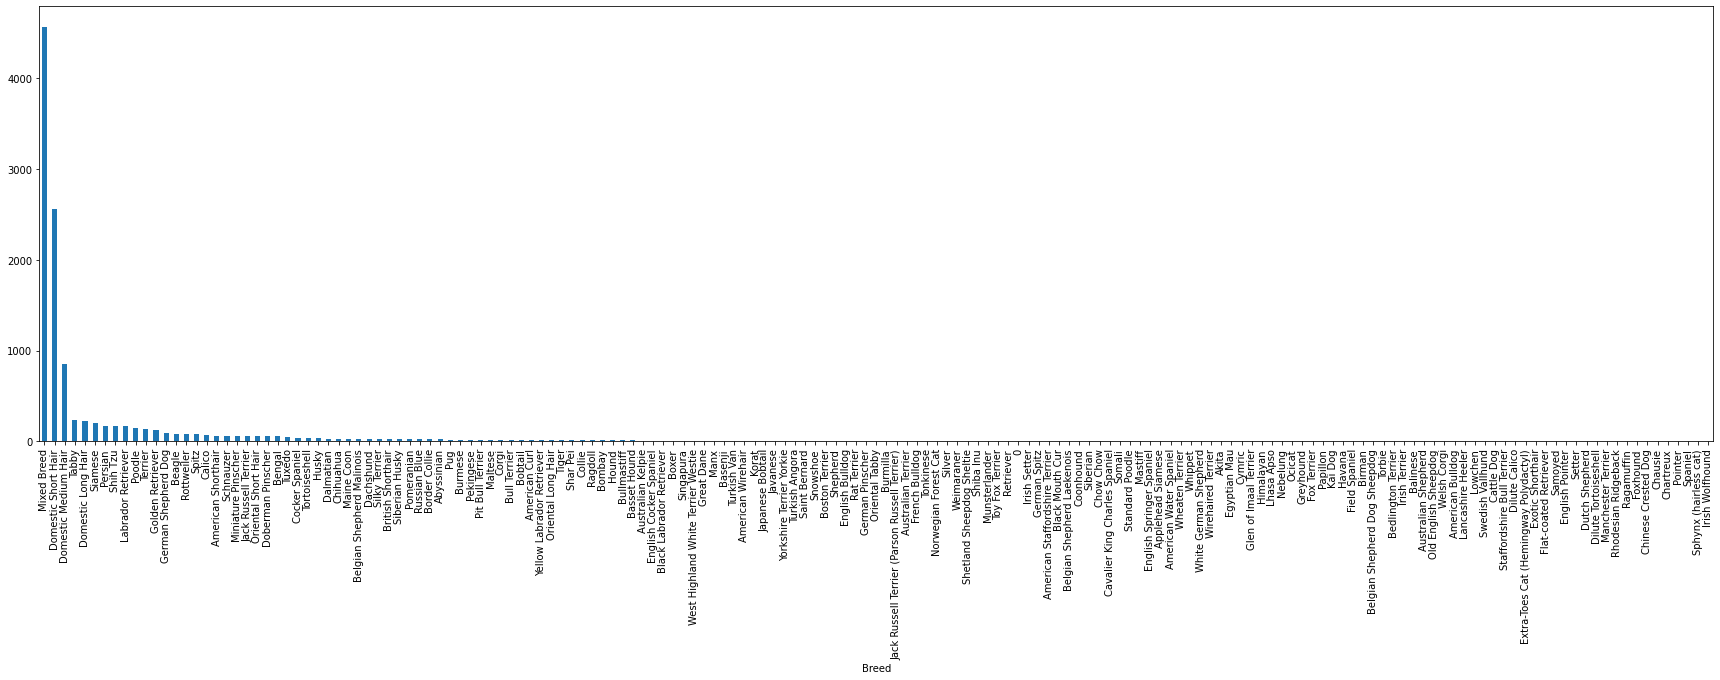

In [17]:
#plot the distribution of the number of entries per breed
df.groupby(['Breed']).count()['PetID'].sort_values(ascending=False).plot(kind='bar', figsize=(30, 8))

With our data ready, let's begin preparing our dataset.

In [18]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = pathlib.Path('./train')

In [109]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28410 files belonging to 2 classes.
Using 22728 files for training.


In [110]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28410 files belonging to 2 classes.
Using 5682 files for validation.


In [8]:
normalization_layer = layers.Rescaling(1./255)

In [102]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.054901965 1.0


In [107]:
class_names = train_ds.class_names
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [104]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [106]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
711/711 [==============================] - 461s 646ms/step - loss: 0.6317 - accuracy: 0.6457 - val_loss: 0.5894 - val_accuracy: 0.6892
Epoch 2/10
711/711 [==============================] - 435s 611ms/step - loss: 0.5514 - accuracy: 0.7185 - val_loss: 0.5588 - val_accuracy: 0.7117
Epoch 3/10
711/711 [==============================] - 441s 620ms/step - loss: 0.4820 - accuracy: 0.7682 - val_loss: 0.5315 - val_accuracy: 0.7357
Epoch 4/10
711/711 [==============================] - 445s 626ms/step - loss: 0.3974 - accuracy: 0.8163 - val_loss: 0.5758 - val_accuracy: 0.7357
Epoch 5/10
711/711 [==============================] - 449s 631ms/step - loss: 0.2955 - accuracy: 0.8710 - val_loss: 0.6161 - val_accuracy: 0.7469
Epoch 6/10
711/711 [==============================] - 454s 638ms/step - loss: 0.1957 - accuracy: 0.9201 - val_loss: 0.7648 - val_accuracy: 0.7314
Epoch 7/10
711/711 [==============================] - 461s 648ms/step - loss: 0.1249 - accuracy: 0.9531 - val_loss: 0.9144 -

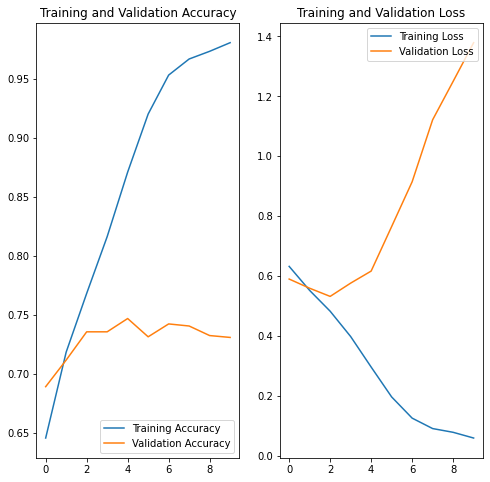

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [29]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [32]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
711/711 [==============================] - 478s 670ms/step - loss: 0.6431 - accuracy: 0.6304 - val_loss: 0.6526 - val_accuracy: 0.6264
Epoch 2/15
711/711 [==============================] - 485s 682ms/step - loss: 0.5936 - accuracy: 0.6829 - val_loss: 0.5725 - val_accuracy: 0.6969
Epoch 3/15
711/711 [==============================] - 491s 691ms/step - loss: 0.5697 - accuracy: 0.7019 - val_loss: 0.5592 - val_accuracy: 0.7080
Epoch 4/15
711/711 [==============================] - 494s 695ms/step - loss: 0.5529 - accuracy: 0.7185 - val_loss: 0.5459 - val_accuracy: 0.7203
Epoch 5/15
711/711 [==============================] - 497s 698ms/step - loss: 0.5378 - accuracy: 0.7301 - val_loss: 0.5406 - val_accuracy: 0.7244
Epoch 6/15
711/711 [==============================] - 500s 703ms/step - loss: 0.5264 - accuracy: 0.7364 - val_loss: 0.5210 - val_accuracy: 0.7358
Epoch 7/15
711/711 [==============================] - 509s 716ms/step - loss: 0.5104 - accuracy: 0.7491 - val_loss: 0.5180 -

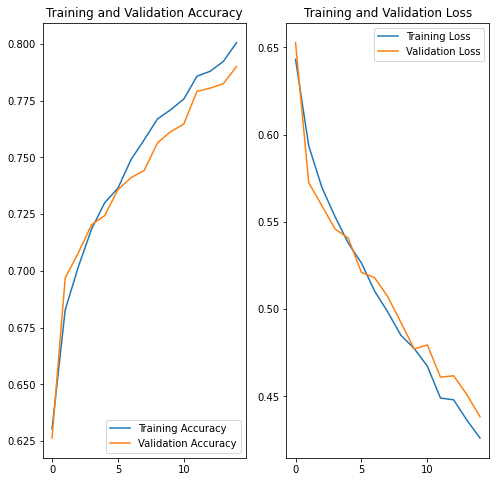

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [95]:
test_images_path = './test_images'

data_dir = pathlib.Path('test_images/fe42c1ee7-3.jpg')
display_image = PIL.Image.open(str(data_dir))
display_image.show()

img = tf.keras.utils.load_img(
    data_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 2s 2s/step
This image most likely belongs to dogs with a 63.71 percent confidence.



(viewnior:26543): Gtk-WARNING **: 18:57:43.749: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.749: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.749: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.758: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.759: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.759: Unable to locate theme engine in module_path: "murrine",

(viewnior:26543): Gtk-WARNING **: 18:57:43.760: Unable to locate theme engine in module_path: "murrine",


Having already classified cats and dogs, a further interesting topic would be a breed classification among the species.

#### Breed classification

We already altered our dataframe to contain the breeds for us, so the data manipulation is no longer required. All we need to do now, is create our training directories.

First of all, we will create the top-level directories.

In [56]:
train_images_path = './train_images'
out_path = './train_breeds'

create_directory(f'{out_path}')
create_directory(f'{out_path}/dogs')
create_directory(f'{out_path}/cats')

In [58]:
import string

def remove_whitespaces(name):
    return name.translate({ord(c): None for c in string.whitespace})

for _, row in df.iterrows():
    files = os.listdir(train_images_path)
    pet_id_images = [ os.path.join(train_images_path, image) for image in files if os.path.isfile(os.path.join(train_images_path, image)) and row['PetID'] in image ]
    for image in pet_id_images:
        if not row['Species'] in ['dog', 'cat']:
            continue

        dir_path = os.path.join(out_path, str(row['Species']) + 's', remove_whitespaces(str(row['Breed']).replace("/", "_")))
        
        if not (os.path.exists(dir_path) and os.path.isdir(dir_path)):
            create_directory(dir_path)
        shutil.copy(image, dir_path)

In [103]:
dog_data_dir = pathlib.Path('./train_breeds/dogs')

In [104]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dog_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22720 files belonging to 107 classes.
Using 18176 files for training.


In [105]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dog_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22720 files belonging to 107 classes.
Using 4544 files for validation.


In [106]:
normalization_layer = layers.Rescaling(1./255)

In [107]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [113]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [110]:
class_names[:10:]

['Akita',
 'AmericanBulldog',
 'AmericanStaffordshireTerrier',
 'AmericanWaterSpaniel',
 'AustralianKelpie',
 'AustralianShepherd',
 'AustralianTerrier',
 'Basenji',
 'BassetHound',
 'Beagle']

In [115]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [116]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [117]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [118]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_17 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [119]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
568/568 [==============================] - 425s 744ms/step - loss: 1.6822 - accuracy: 0.7099 - val_loss: 1.6117 - val_accuracy: 0.7163
Epoch 2/10
568/568 [==============================] - 446s 786ms/step - loss: 1.6309 - accuracy: 0.7110 - val_loss: 1.5884 - val_accuracy: 0.7163
Epoch 3/10
568/568 [==============================] - 453s 796ms/step - loss: 1.6164 - accuracy: 0.7111 - val_loss: 1.5685 - val_accuracy: 0.7163
Epoch 4/10
568/568 [==============================] - 464s 816ms/step - loss: 1.6006 - accuracy: 0.7110 - val_loss: 1.5702 - val_accuracy: 0.7161
Epoch 5/10
568/568 [==============================] - 453s 797ms/step - loss: 1.5953 - accuracy: 0.7112 - val_loss: 1.5587 - val_accuracy: 0.7163
Epoch 6/10
568/568 [==============================] - 456s 802ms/step - loss: 1.5777 - accuracy: 0.7109 - val_loss: 1.5581 - val_accuracy: 0.7165
Epoch 7/10
568/568 [==============================] - 459s 808ms/step - loss: 1.5661 - accuracy: 0.7109 - val_loss: 1.5501 -

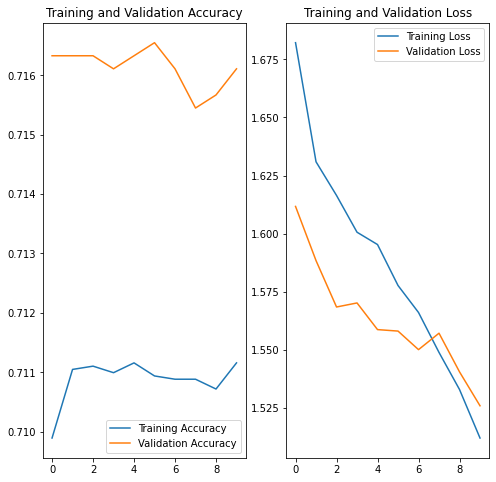

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [121]:
test_images_path = './test_images'

data_dir = pathlib.Path('train_breeds/dogs/Dalmatian/0ab8ae91b-1.jpg')
display_image = PIL.Image.open(str(data_dir))
display_image.show()

img = tf.keras.utils.load_img(
    data_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 451ms/step
This image most likely belongs to MixedBreed with a 77.21 percent confidence.



(viewnior:40811): Gtk-WARNING **: 21:04:22.422: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.422: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.422: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.424: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.424: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.424: Unable to locate theme engine in module_path: "murrine",

(viewnior:40811): Gtk-WARNING **: 21:04:22.424: Unable to locate theme engine in module_path: "murrine",


As we can see, the training did not go to well, and that is mostly due to certain breeds having significantly more images than others.
So, for improving our accuracy, we will reduce our dataset to the four breeds that have the most images.

In [83]:
cat_data_dir = pathlib.Path('./train_breeds/cats')

In [84]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  cat_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18990 files belonging to 57 classes.
Using 15192 files for training.


In [85]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  cat_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18990 files belonging to 57 classes.
Using 3798 files for validation.


In [86]:
normalization_layer = layers.Rescaling(1./255)

In [91]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.045969523 0.6603486


In [92]:
class_names = train_ds.class_names
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [98]:
class_names[:10:]

['Abyssinian',
 'AmericanCurl',
 'AmericanShorthair',
 'AmericanWirehair',
 'AppleheadSiamese',
 'Balinese',
 'Bengal',
 'Birman',
 'Bobtail',
 'Bombay']

In [99]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [100]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
475/475 [==============================] - 321s 673ms/step - loss: 1.8346 - accuracy: 0.5375 - val_loss: 1.7671 - val_accuracy: 0.5424
Epoch 2/10
475/475 [==============================] - 351s 737ms/step - loss: 1.7784 - accuracy: 0.5421 - val_loss: 1.7729 - val_accuracy: 0.5419
Epoch 3/10
475/475 [==============================] - 347s 730ms/step - loss: 1.7285 - accuracy: 0.5410 - val_loss: 1.7923 - val_accuracy: 0.5390
Epoch 4/10
475/475 [==============================] - 350s 736ms/step - loss: 1.5824 - accuracy: 0.5518 - val_loss: 1.9127 - val_accuracy: 0.5187
Epoch 5/10
475/475 [==============================] - 352s 741ms/step - loss: 1.2826 - accuracy: 0.6027 - val_loss: 2.3884 - val_accuracy: 0.4779
Epoch 6/10
475/475 [==============================] - 350s 737ms/step - loss: 0.8687 - accuracy: 0.7112 - val_loss: 3.4950 - val_accuracy: 0.4523
Epoch 7/10
475/475 [==============================] - 349s 735ms/step - loss: 0.5416 - accuracy: 0.8098 - val_loss: 4.4326 -

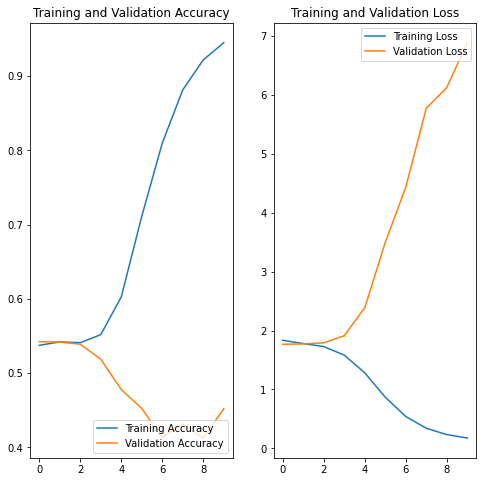

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [102]:
test_images_path = './test_images'

data_dir = pathlib.Path('train_breeds/cats/Bobtail/3d939327d-2.jpg')
display_image = PIL.Image.open(str(data_dir))
display_image.show()

img = tf.keras.utils.load_img(
    data_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


(viewnior:37688): Gtk-WARNING **: 19:33:05.639: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.639: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.639: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.642: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.642: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.642: Unable to locate theme engine in module_path: "murrine",

(viewnior:37688): Gtk-WARNING **: 19:33:05.642: Unable to locate theme engine in module_path: "murrine",


1/1 [==============================] - 1s 1s/step
This image most likely belongs to DomesticShortHair with a 94.20 percent confidence.
